# Demo: TensorFlow を使った手書き文字認識

## 問題設定

手書きの数字の画像が与えられたとき，それが 1~9 のどれであるかを判別する．

<img src=img/MNIST.png>

## Convolutional Neural Network (畳み込みニューラルネットワーク)

### 学習

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Load MNIST data set
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# input_data モジュールは MNIST データを長さ 784 の配列として読み込むのでその形に合わせる
x_ph = tf.placeholder(tf.float32, shape=[None, 784])
# 畳み込みニューラルネットでは [batch_size x height x width x n_channels] の Tensor を入力とするので reshape する
x_image_ph = tf.reshape(x_ph, [-1, 28, 28, 1])
# 出力は [batch_size x n_classes]
y_ph = tf.placeholder(tf.float32, shape=[None, 10])

w_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))

h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image_ph, w_conv1, strides=[1, 1, 1, 1], padding="SAME"))
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

w_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding="SAME") + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

# 2 つ目の pooling 層の出力を一般的な feed forward neural network に流すために平らにしている
w_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ph * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
pred_cnn = tf.argmax(y_conv, 1)
correct_prediction = tf.equal(tf.argmax(y_ph,1), pred_cnn)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(1000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x_ph: batch[0], y_ph: batch[1], keep_prob: 1.0}, session=sess)
        print "step %d, training accuracy %g"%(i, train_accuracy)
    train_step.run(feed_dict={x_ph: batch[0], y_ph: batch[1], keep_prob: 0.5}, session=sess)

print "test accuracy %g"%accuracy.eval(feed_dict={x_ph: mnist.test.images, y_ph: mnist.test.labels, keep_prob: 1.0}, session=sess)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.1
step 100, training accuracy 0.8
step 200, training accuracy 0.94
step 300, training accuracy 0.88
step 400, training accuracy 1
step 500, training accuracy 0.92
step 600, training accuracy 0.98
step 700, training accuracy 0.94
step 800, training accuracy 0.94
step 900, training accuracy 0.98
test accuracy 0.965


### 予測

In [2]:
%matplotlib inline

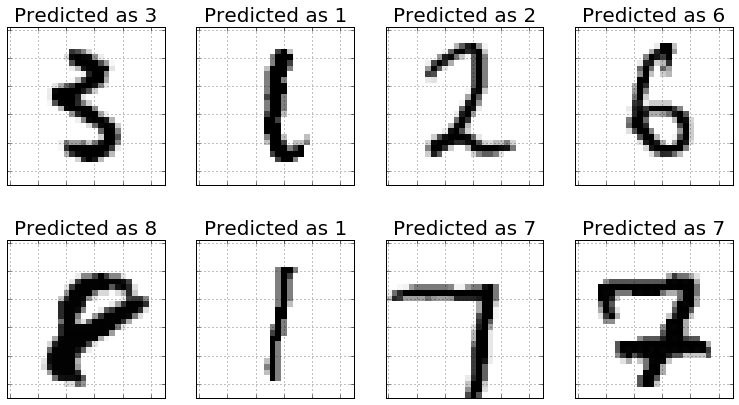

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

n_row = 2
n_col = 4

pred = sess.run(pred_cnn, feed_dict={x_ph: mnist.test.images, keep_prob: 1})
ind = np.random.choice(1000, n_row*n_col, replace=False)

plt.figure(figsize=(13, 7))
for i in range(n_row*n_col):
    pos = int(str(n_row) + str(n_col) + str(i+1))
    plt.subplot(pos)
    plt.imshow(mnist.test.images[ind[i]].reshape([28, 28]), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Predicted as {}".format(pred[ind[i]]), fontsize=20)
    plt.grid()
    plt.tick_params(labelbottom='off', labelleft='off')
plt.show()

## Resources

* [Deep MNIST for Experts](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html)